In [7]:
import numpy as np
import qutip as qt
from scipy.linalg import logm, expm
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
import matplotlib.pyplot as plt
from qiskit.circuit.library import QFT


import sys
sys.path.append('/Users/bence/code/liouvillian_metro/')

from unitary.op_fourier_trafo_unitary import brute_prepare_gaussian_state

In [2]:
def signed_order_counts(counts: dict, num_energy_bits: int) -> dict:
    bitstrings_pos = [bin(i)[2:].zfill(num_energy_bits - 1) for i in range(2**(num_energy_bits - 1))]
    bitstrings_pos = ['0' + bitstring for bitstring in bitstrings_pos]
    bitstrings_neg = [bin(i)[2:].zfill(num_energy_bits - 1) for i in range(2**(num_energy_bits - 1))]
    bitstrings_neg = ['1' + bitstring for bitstring in bitstrings_neg]
    bitstrings_ordered = bitstrings_neg + bitstrings_pos
    for bitstring in bitstrings_ordered:
        if bitstring not in counts.keys():
            counts[bitstring] = 0
    counts_ordered = {bitstrings_ordered[i]: counts[bitstrings_ordered[i]] 
                    for i in range(len(bitstrings_ordered)) if bitstrings_ordered[i] in counts.keys()}
    return counts_ordered

### Normal Gauss

/Users/bence/miniforge3/envs/qiskit_1_env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/bence/miniforge3/envs/qiskit_1_env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


<BarContainer object of 64 artists>

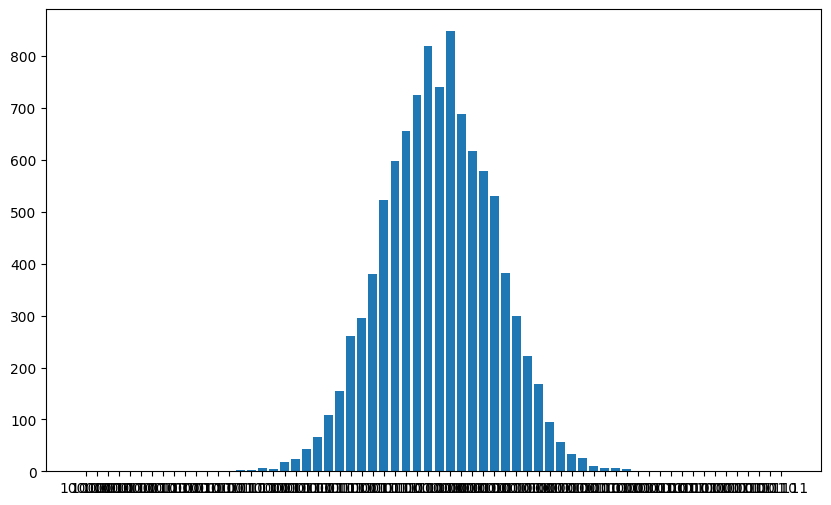

In [3]:
sigma = 5
num_energy_bits = 6
N = 2**num_energy_bits

N_labels = np.arange(N / 2, dtype=int)
N_labels_neg = np.arange(- N / 2, 0, dtype=int)
N_labels = np.concatenate((N_labels, N_labels_neg))
time_labels = N_labels
energy_labels = 2 * np.pi * N_labels / N

qr_energy = QuantumRegister(num_energy_bits, name="qr_w")
cr_energy = ClassicalRegister(num_energy_bits, name="cr_w")
circ = QuantumCircuit(qr_energy, cr_energy)
gauss = brute_prepare_gaussian_state(num_energy_bits, sigma)

circ.compose(gauss, qr_energy, inplace=True)
circ.measure(qr_energy, cr_energy)
tr_circ = transpile(circ, basis_gates=['u', 'cx'], optimization_level=3)

simulator = Aer.get_backend('statevector_simulator')
shots = 10000
job = simulator.run(tr_circ, shots=shots)
counts = job.result().get_counts()
counts_ordered = signed_order_counts(counts, num_energy_bits)

plt.figure(figsize=(10,6))
plt.bar(counts_ordered.keys(), counts_ordered.values())

Note, that this is practically already a truncateed Gaussian, and there isn't really any tail here far away. But mathematically, it seems to be important to use some STD and a truncations instead of using a smaller STD. But that then resembles to a rectangle, making the Gaussian less of a Gaussian no?

### Fourier trafod Gauss

<BarContainer object of 64 artists>

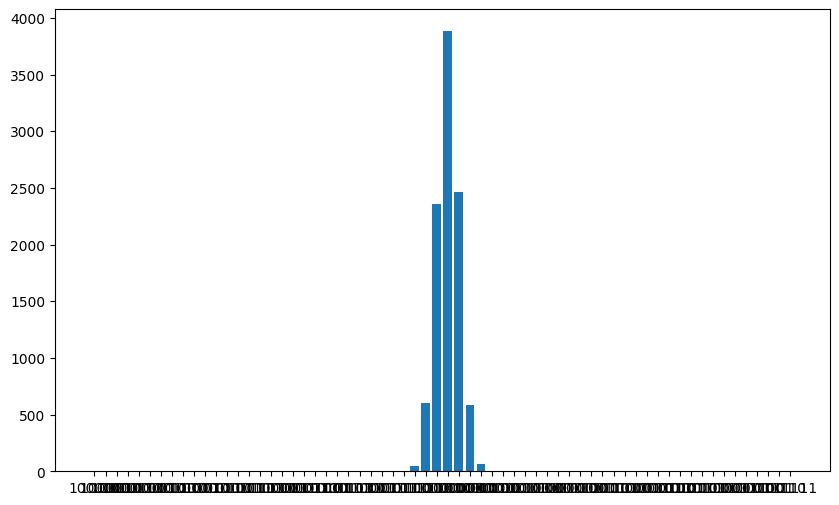

In [4]:
def discrete_fourier_trafo():
    ...
    
DFT_gauss_amplitudes = lambda energy: np.sqrt(sigma * np.sqrt(2 * np.pi)) * np.exp(- sigma**2 * energy**2)
dft_amplitudes = []
for energy in energy_labels:
    dft_amplitudes.append(DFT_gauss_amplitudes(energy))
    
dft_amplitudes /= np.linalg.norm(dft_amplitudes)

dft_prep_circ = QuantumCircuit(num_energy_bits, name="gauss")
dft_prep_circ.initialize(dft_amplitudes, range(num_energy_bits))

qr_energy = QuantumRegister(num_energy_bits, name="qr_w")
cr_energy = ClassicalRegister(num_energy_bits, name="cr_w")
circ = QuantumCircuit(qr_energy, cr_energy)

circ.compose(dft_prep_circ, qr_energy, inplace=True)
circ.measure(qr_energy, cr_energy)
tr_circ = transpile(circ, basis_gates=['u', 'cx'], optimization_level=3)

simulator = Aer.get_backend('statevector_simulator')
shots = 10000
job = simulator.run(tr_circ, shots=shots)
counts = job.result().get_counts()
counts_ordered = signed_order_counts(counts, num_energy_bits)

plt.figure(figsize=(10,6))
plt.bar(counts_ordered.keys(), counts_ordered.values())


### What Qiskit QFT does

In [44]:
qr_energy = QuantumRegister(num_energy_bits, name="qr_w")
cr_energy = ClassicalRegister(num_energy_bits, name="cr_w")
circ = QuantumCircuit(qr_energy, cr_energy)
gauss = brute_prepare_gaussian_state(num_energy_bits, sigma)
qft = QFT(num_energy_bits, do_swaps=True, inverse=True)

circ.compose(gauss, qr_energy, inplace=True)
circ.compose(qft, qr_energy, inplace=True)
circ_state = Statevector(circ).data


ft_gauss = lambda energy: np.exp(-sigma**2 * energy**2)
ft_gauss_amplitudes = np.array([ft_gauss(energy) for energy in energy_labels])  # Binary ordered
ft_gauss_amplitudes /= np.linalg.norm(ft_gauss_amplitudes)
# ft_gauss_amplitudes /= (2 * sigma * np.sqrt(np.pi)/ np.sqrt(N))  #! Failed finding the correct normalization by hand


# Compare
dist_gauss = np.linalg.norm(circ_state - ft_gauss_amplitudes)
print(f'Distance between circuit QFT and expected QFT of Gaussian: {dist_gauss}')


Distance between circuit QFT and expected QFT of Gaussian: 0.2787927714098473
